In [2]:
import os, platform, torch, torchaudio
print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Torchaudio:", torchaudio.__version__)
print("CUDA available?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("CWD:", os.getcwd())


Python: 3.11.7
Torch: 2.8.0+cu128
Torchaudio: 2.8.0+cu128
CUDA available?: True
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU
CWD: c:\SW_3_2\ai\AI_lab\test


In [3]:
from pathlib import Path

# week3.ipynb 위치 기준으로 여러 후보를 순차 확인
CANDIDATES = [
    Path("./audio_dataset"),
    Path("./test/audio_dataset"),
    Path("../test/audio_dataset"),
    Path("../audio_dataset"),
]

DATASET_DIR = next((p for p in CANDIDATES if p.exists()), None)
assert DATASET_DIR is not None, f"audio_dataset 폴더를 찾지 못했습니다.\n시도한 경로: {CANDIDATES}"

OUTPUT_DIR = Path("./outputs_w3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".ogg", ".m4a", ".aac"}
files = sorted([p for p in DATASET_DIR.rglob("*") if p.suffix.lower() in AUDIO_EXTS])
print(f"Found {len(files)} audio files in: {DATASET_DIR.resolve()}")
for i, f in enumerate(files): print(f"[{i}] {f}")
assert files, "오디오 파일이 없습니다."


Found 4 audio files in: C:\SW_3_2\ai\AI_lab\test\audio_dataset
[0] audio_dataset\095522039.m4a
[1] audio_dataset\095522040.m4a
[2] audio_dataset\095522041.m4a
[3] audio_dataset\095522042.m4a


In [4]:
import subprocess, json, numpy as np, torch, torchaudio
from pathlib import Path

def _probe_ffprobe(path: str):
    """ffprobe로 채널/샘플레이트 확인 (없으면 None 반환)"""
    try:
        cmd = [
            "ffprobe", "-v", "error", "-select_streams", "a:0",
            "-show_entries", "stream=channels,sample_rate",
            "-of", "json", path
        ]
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT)
        info = json.loads(out.decode("utf-8"))
        s = info["streams"][0]
        ch = int(s.get("channels", 1))
        sr = int(s.get("sample_rate", 48000))
        return ch, sr
    except Exception:
        return None

def _load_with_external_ffmpeg(path: str, target_sr=None):
    """외부 ffmpeg로 디코드 → float32 PCM을 파이프로 읽어 텐서로 변환"""
    meta = _probe_ffprobe(path)
    if meta is None:
        # 메타 못 읽었으면 합리적 기본값
        ch, sr = 1, 48000
    else:
        ch, sr = meta

    out_sr = target_sr if (target_sr and target_sr > 0) else sr
    # -f f32le -acodec pcm_f32le : 32-bit float interleaved
    cmd = [
        "ffmpeg", "-v", "error", "-i", path,
        "-f", "f32le", "-acodec", "pcm_f32le",
        "-ar", str(out_sr), "-ac", str(ch), "pipe:1"
    ]
    proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    raw = proc.stdout
    # float32 interleaved -> (samples, ch)
    data = np.frombuffer(raw, dtype=np.float32)
    if ch > 0:
        data = data.reshape(-1, ch)
    else:
        data = data.reshape(-1, 1)
    # (ch, samples) 텐서로
    w = torch.from_numpy(np.ascontiguousarray(data.T))
    return w, out_sr

def load_audio_best(path, target_sr=None):
    """
    1) torchaudio.load
    2) torchaudio.load_with_torchcodec (있으면)
    3) torchcodec.AudioDecoder (설치돼 있으면)
    4) 외부 ffmpeg 파이프 (항상 가능; ffmpeg -version 인식 필수)
    """
    path = str(Path(path))
    # 1) torchaudio 기본
    try:
        w, sr = torchaudio.load(path)
        # 필요시 리샘플
        if target_sr and sr != target_sr:
            w = torchaudio.transforms.Resample(sr, target_sr)(w)
            sr = target_sr
        return w, sr
    except Exception:
        pass

    # 2) torchaudio.load_with_torchcodec
    try:
        if hasattr(torchaudio, "load_with_torchcodec"):
            w, sr = torchaudio.load_with_torchcodec(path)
            if target_sr and sr != target_sr:
                w = torchaudio.transforms.Resample(sr, target_sr)(w)
                sr = target_sr
            return w, sr
    except Exception:
        pass

    # 3) torchcodec 직접
    try:
        from torchcodec.decoders import AudioDecoder
        dec = AudioDecoder(path)
        audio = dec.decode_all()  # (time, ch)
        sr = dec.sample_rate
        if audio.ndim == 1:
            audio = audio[:, None]
        w = torch.from_numpy(np.ascontiguousarray(audio.T)).float()
        if target_sr and sr != target_sr:
            w = torchaudio.transforms.Resample(sr, target_sr)(w)
            sr = target_sr
        return w, sr
    except Exception:
        pass

    # 4) 외부 ffmpeg 파이프 (최후 수단)
    w, sr = _load_with_external_ffmpeg(path, target_sr)
    return w, sr


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_13740\2682659342.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\a

Loaded: 095522039.m4a | shape: (1, 177152) | sr: 44100


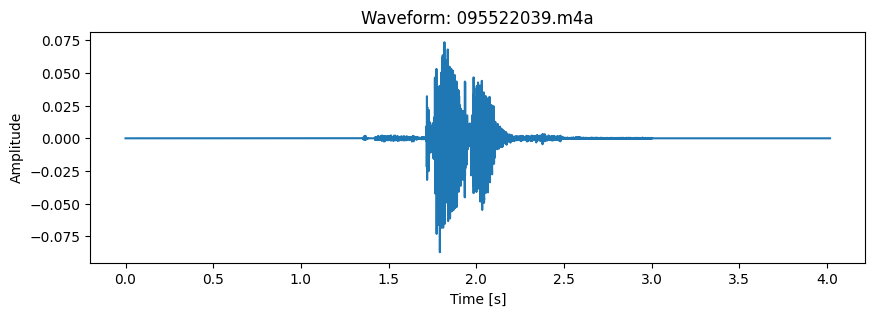

In [5]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate, title, save_path=None):
    plt.figure(figsize=(10, 3))
    x = waveform[0].cpu().numpy() if waveform.ndim == 2 else waveform.cpu().numpy()
    t = [i / sample_rate for i in range(len(x))]
    plt.plot(t, x)
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

test_path = files[0]
waveform, sr = load_audio_best(test_path)
print("Loaded:", test_path.name, "| shape:", tuple(waveform.shape), "| sr:", sr)

plot_waveform(waveform, sr, f"Waveform: {test_path.name}",
              OUTPUT_DIR / f"waveform_{test_path.stem}.png")


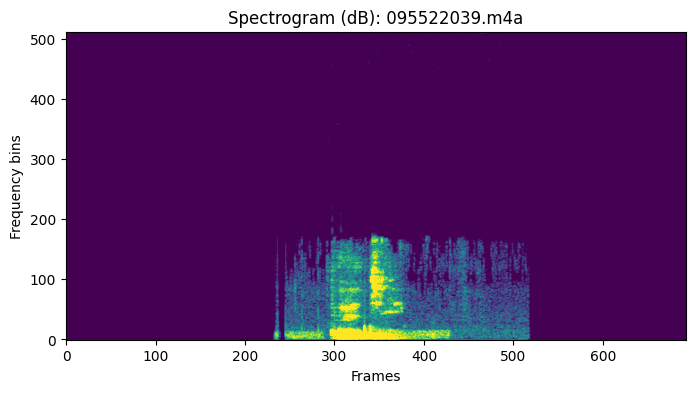

In [9]:
from torchaudio.transforms import Spectrogram, AmplitudeToDB
import torch, matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mono = waveform[0:1].to(device) if waveform.ndim == 2 else waveform.unsqueeze(0).to(device)

spec = Spectrogram(n_fft=1024, hop_length=256, power=2.0).to(device)
S = spec(mono)  # power spectrogram

# dB 스케일 변환 + 시각화 범위 자동화
amp2db = AmplitudeToDB(stype="power", top_db=80).to(device)
S_db = amp2db(S)  # (1, freq, time)

Snp = S_db[0].detach().cpu().numpy()
vmin = float(torch.quantile(S_db, 0.05))   # 하위 5%
vmax = float(torch.quantile(S_db, 0.995))  # 상위 99.5%

plt.figure(figsize=(8,4))
plt.imshow(Snp, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
plt.title(f"Spectrogram (dB): {test_path.name}")
plt.xlabel("Frames"); plt.ylabel("Frequency bins")
plt.savefig(OUTPUT_DIR / f"spectrogram_{test_path.stem}.png", bbox_inches="tight", dpi=150)
plt.show()


Original: torch.Size([1, 177152]) sr: 44100
Down   : torch.Size([1, 64273]) sr: 16000
Up     : torch.Size([1, 177153]) sr: 44100


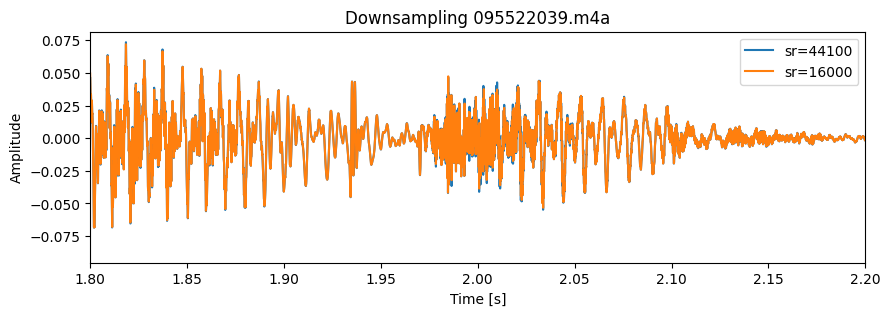

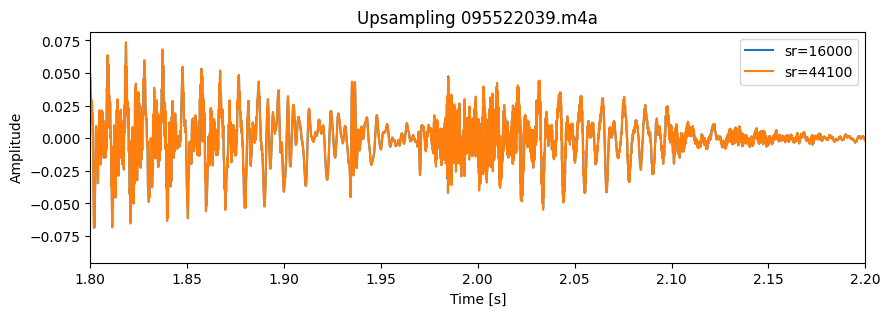

In [11]:
from torchaudio.transforms import Resample

orig_sr = sr
down_sr = 16000
up_sr   = orig_sr

wave = waveform.to(device)

downsampler = Resample(orig_freq=orig_sr, new_freq=down_sr).to(device)
upsampler   = Resample(orig_freq=down_sr, new_freq=up_sr).to(device)

wave_down = downsampler(wave)
wave_up   = upsampler(wave_down)

print("Original:", wave.shape, "sr:", orig_sr)
print("Down   :", wave_down.shape, "sr:", down_sr)
print("Up     :", wave_up.shape, "sr:", up_sr)

def plot_compare_waves(w1, sr1, w2, sr2, title, save_path=None, time_range=None):
    """
    w1, w2: waveforms (channels, samples)
    sr1, sr2: sample rates
    time_range: (start_sec, end_sec) 튜플. 지정하면 그 구간만 확대.
    """
    import matplotlib.pyplot as plt
    
    x1 = w1[0].detach().cpu().numpy()
    x2 = w2[0].detach().cpu().numpy()
    t1 = [i/sr1 for i in range(len(x1))]
    t2 = [i/sr2 for i in range(len(x2))]
    
    plt.figure(figsize=(10, 3))
    plt.plot(t1, x1, label=f"sr={sr1}")
    plt.plot(t2, x2, label=f"sr={sr2}")
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Amplitude"); plt.legend()
    
    if time_range:
        plt.xlim(*time_range)  # 줌인
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()
    
plot_compare_waves(wave, orig_sr, wave_down, down_sr,
                   f"Downsampling {test_path.name}",
                   OUTPUT_DIR / f"downsample_zoom_{test_path.stem}.png",
                   time_range=(1.8, 2.2))

plot_compare_waves(wave_down, down_sr, wave_up, up_sr,
                   f"Upsampling {test_path.name}",
                   OUTPUT_DIR / f"upsample_zoom_{test_path.stem}.png",
                   time_range=(1.8, 2.2))
